In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import FastICA, PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
from scipy import linalg
import matplotlib as mpl
import itertools
from sklearn import random_projection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn import datasets
from scipy.stats import kurtosis 
import numpy as np  
import pylab as p  



np.random.seed(42)

## Data Preparation

In [3]:
student = pd.read_csv("student-por.csv" ,sep=';')
student.columns = ['school','sex','age','address','family_size','parents_status','mother_education','father_education',
           'mother_job','father_job','reason','guardian','commute_time','study_time','failures','school_support',
          'family_support','paid_classes','activities','nursery','desire_higher_edu','internet','romantic','family_quality',
          'free_time','go_out','weekday_alcohol_usage','weekend_alcohol_usage','health','absences','period1_score','period2_score','final_score']
# convert final_score to categorical variable # Good:15~20 Fair:10~14 Poor:0~9
student['final_grade'] = 'na'
student.loc[(student.final_score >= 15) & (student.final_score <= 20), 'final_grade'] = 'good' 
student.loc[(student.final_score >= 10) & (student.final_score <= 14), 'final_grade'] = 'fair' 
student.loc[(student.final_score >= 0) & (student.final_score <= 9), 'final_grade'] = 'poor'

In [4]:
# create dataframe dfd for classification
data = student.copy()
data = data.drop([ 'final_score'], axis=1)
# label encode final_grade
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data.final_grade = le.fit_transform(data.final_grade)

In [5]:
# dataset train_test_split
X = data.drop('final_grade',axis=1)
y = data.final_grade

In [6]:
def normalization(X):
    mean = np.mean(X)
    std = np.std(X)
    X_t = (X - mean)/std
    return X_t

In [7]:
#Normalization
X_t = normalization(X)
print("X_t:", X_t.shape)
X = X_t
X=X.dropna(axis=1,how='all')

X_t: (649, 32)


In [8]:
from sklearn import preprocessing, model_selection 
X = preprocessing.normalize(X, axis = 0)
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.3)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(454, 15) (454,) (195, 15) (195,)


## PCA

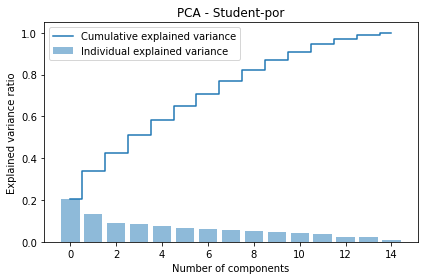

In [10]:
X_train_pca = pca.fit_transform(X_train)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.title('PCA - Student-por')
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [11]:
pca = PCA(n_components = 10)
X_transformed = pca.fit_transform(X_train)
X_projected = pca.inverse_transform(X_transformed)
reconstruction_error = np.sum(np.square(X_train - X_projected))/X_projected.size
reconstruction_error

0.0002036911500227527

## ICA

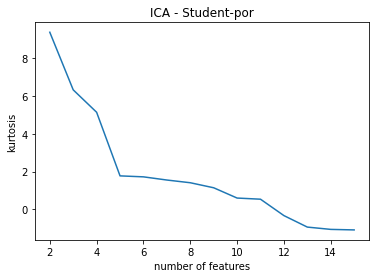

In [13]:
from sklearn.decomposition import FastICA
import scipy
ica = FastICA()
X_reduced = ica.fit_transform(X)


def _calculate(X, ica_, n_components):
    
    components = ica_.components_
    ica_.components_ = components[:n_components]

    transformed = ica_.transform(X)
    ica_.components_ = components
    kurtosis = scipy.stats.kurtosis(transformed)

    return sorted(kurtosis, reverse = True) 
plt.plot(range(2,16),_calculate(X,ica,15)[1:])
plt.title('ICA - Student-por')
plt.xlabel("number of features")
plt.ylabel("kurtosis")
print()

In [14]:
ica = FastICA(n_components = 2)
X_transformed = ica.fit_transform(X_train)
X_projected = ica.inverse_transform(X_transformed)
reconstruction_error = np.sum(np.square(X_train - X_projected))/X_projected.size
reconstruction_error

0.0010239473480988697

## RP

Calculating Reconstruction Error


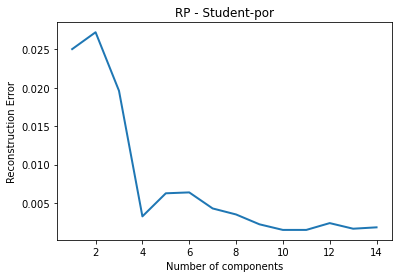

In [15]:
n_components = range(1, X.shape[1])

def inverse_transform_rp(rp, X_transformed, X_train):

    return X_transformed.dot(rp.components_) + np.mean(X_train, axis = 0)



reconstruction_error = []
for comp in n_components:

    rp = random_projection.GaussianRandomProjection(n_components = comp)
    X_transformed = rp.fit_transform(X_train)
    X_projected = inverse_transform_rp(rp, X_transformed, X_train)
    reconstruction_error.append(((X_train - X_projected) ** 2).mean())

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('RP - Student-por')
plt.show()

In [16]:
rp = random_projection.GaussianRandomProjection(n_components = 12)
X_transformed = rp.fit_transform(X_train)
X_projected = inverse_transform_rp(rp, X_transformed, X_train)
reconstruction_error=(((X_train - X_projected) ** 2).mean())
reconstruction_error

0.0020844190301477212

## SVD

14

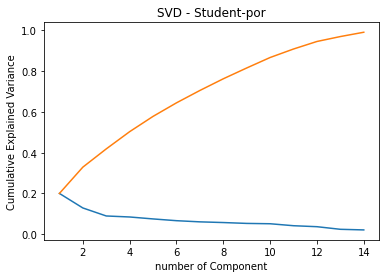

In [49]:
tsvd = TruncatedSVD(n_components=X.shape[1]-1)
X_tsvd = tsvd.fit(X)

tsvd_var_ratios = tsvd.explained_variance_ratio_
plt.plot(range(1, len(tsvd_var_ratios) + 1), tsvd_var_ratios)
plt.plot(range(1, len(tsvd_var_ratios) + 1), np.cumsum(tsvd_var_ratios))
plt.title("SVD - Student-por")
plt.xlabel("number of Component")
plt.ylabel("Cumulative Explained Variance")

# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

select_n_components(tsvd_var_ratios, 0.99)

In [18]:
svd = TruncatedSVD(n_components = 14)
X_transformed = svd.fit_transform(X_train)
X_projected = svd.inverse_transform(X_transformed)
reconstruction_error = np.sum(np.square(X_train - X_projected))/X_projected.size
reconstruction_error

1.3195478898518967e-05

## Prepare new dataset after dimension reduction

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[0,100])
scaler.fit(X)
X_norm = pd.DataFrame(scaler.transform(X))

In [20]:
data = X_norm
labels = y
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

In [21]:
n = 3
pca = PCA(n_components=n) 
X_pca=pd.DataFrame(pca.fit_transform(X))

In [22]:
n = 2
ica = FastICA(n_components=n) 
X_ica=pd.DataFrame(ica.fit_transform(X))

In [23]:
n = 12
rp = random_projection.GaussianRandomProjection(n_components=n) 
X_rp=pd.DataFrame(rp.fit_transform(X))

In [24]:
x_svd = svd.fit_transform(X)
X_svd = pd.DataFrame(x_svd)

## KMeans + PCA

NMI score: 0.226715
For n_clusters = 2 The average silhouette_score is : 0.30059803036758675


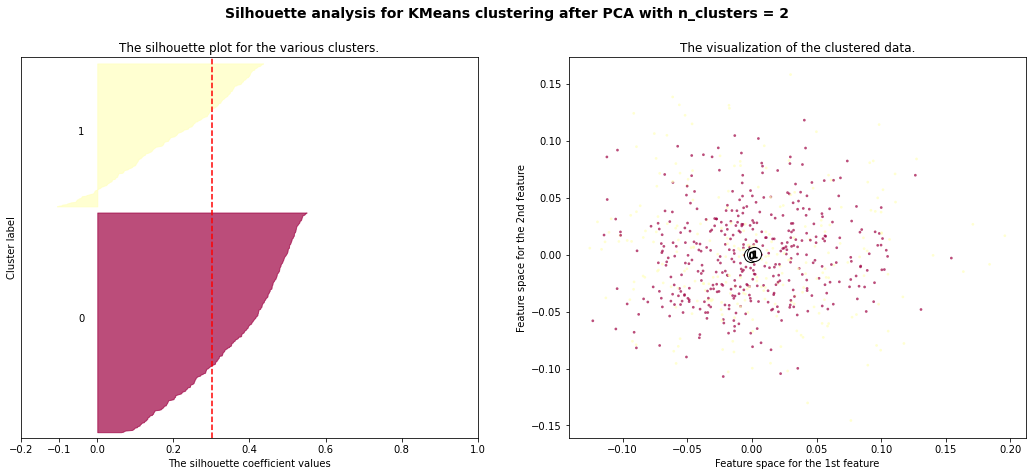

NMI score: 0.171926
For n_clusters = 3 The average silhouette_score is : 0.26692552387346924


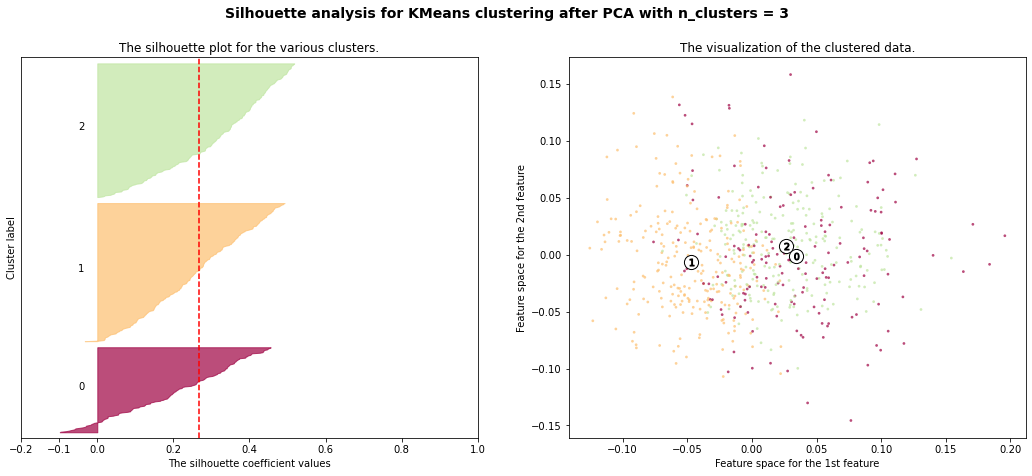

NMI score: 0.161584
For n_clusters = 4 The average silhouette_score is : 0.2592233535396234


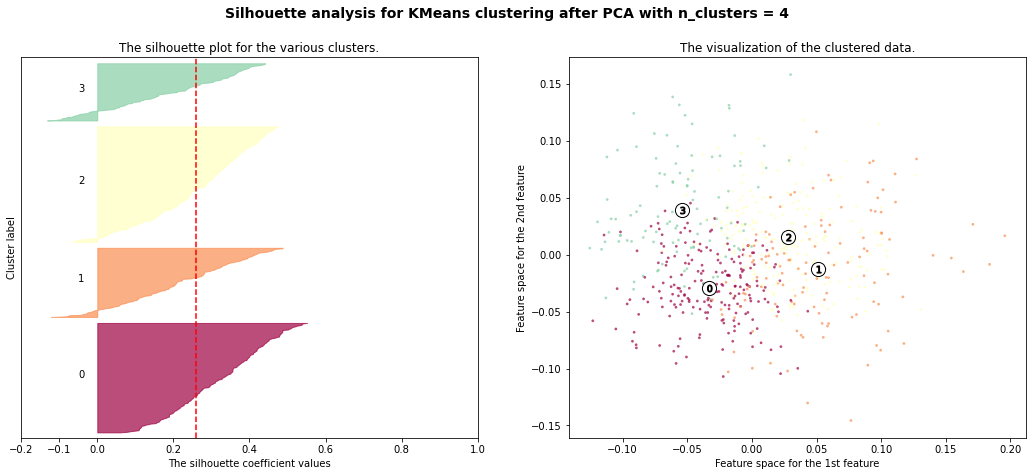

NMI score: 0.172733
For n_clusters = 5 The average silhouette_score is : 0.27454882570436057


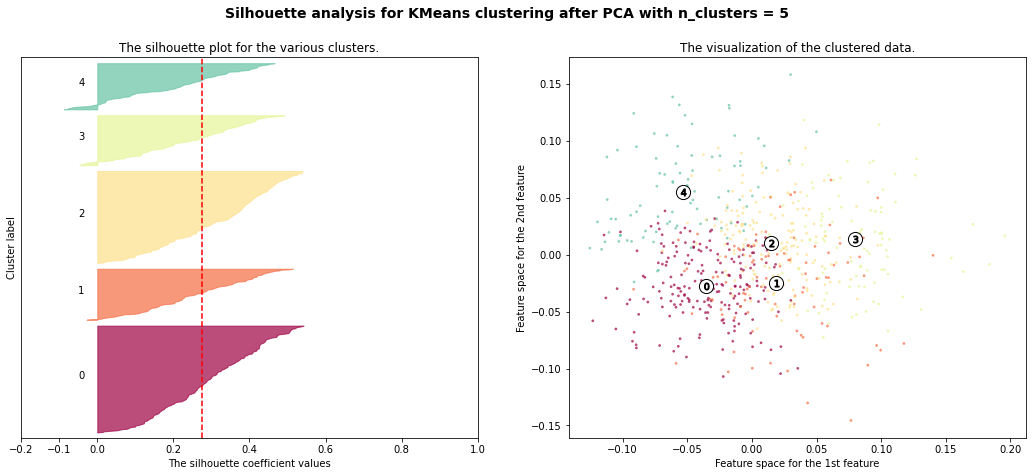

NMI score: 0.185122
For n_clusters = 6 The average silhouette_score is : 0.25597594540363605


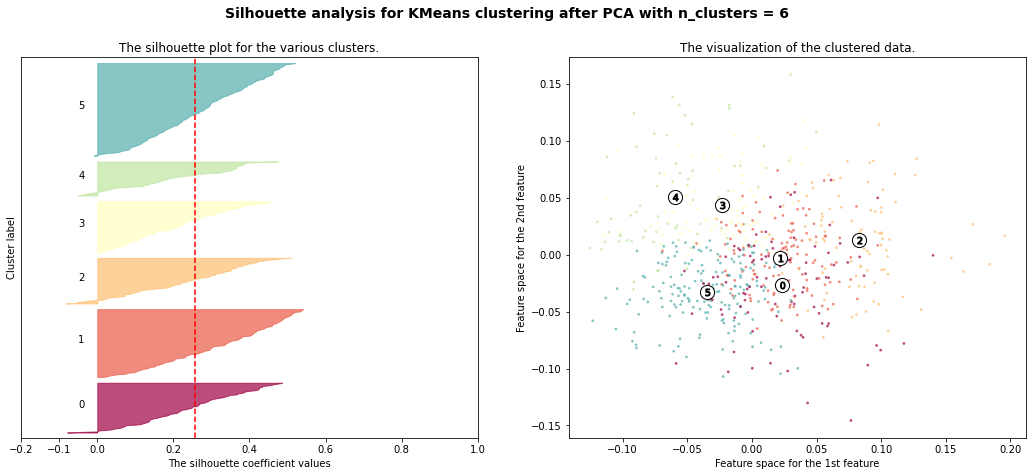

NMI score: 0.171202
For n_clusters = 7 The average silhouette_score is : 0.24917505351019895


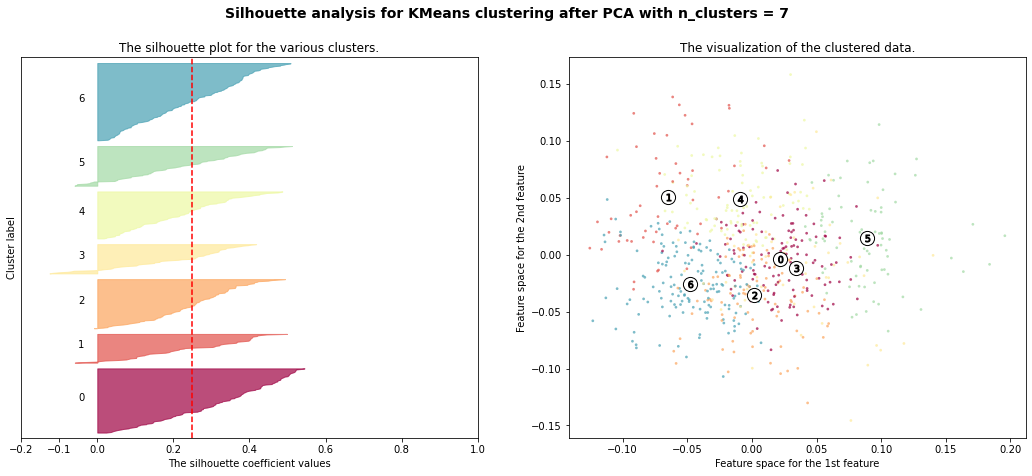

In [50]:
range_n_clusters = [2,3,4,5,6,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_pca)
    cluster_labels = clusterer.labels_
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter( X_pca.iloc[:, 1], X_pca.iloc[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 1], centers[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter( c[1], c[2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering after PCA "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
#     ax2.axis([-5,5,-5,5])

    plt.show()

## GMM + PCA

NMI score: 0.187965


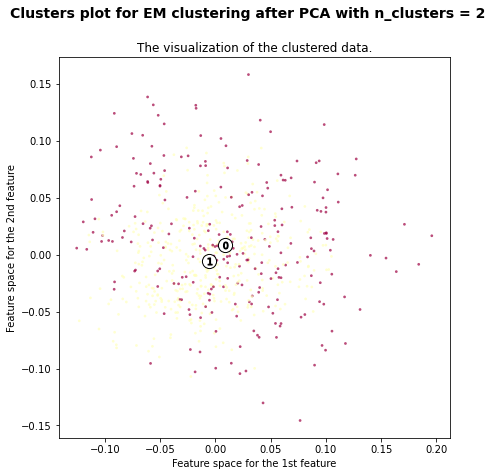

NMI score: 0.180080


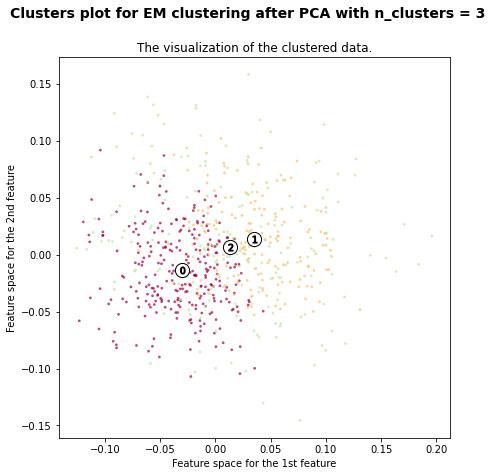

NMI score: 0.153645


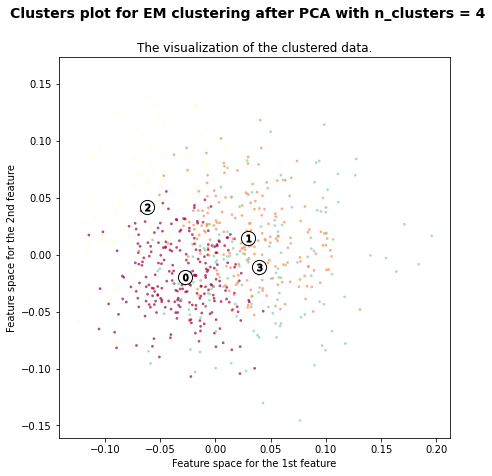

NMI score: 0.156649


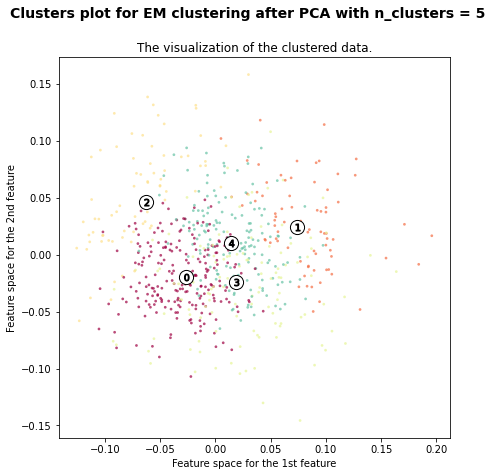

NMI score: 0.160025


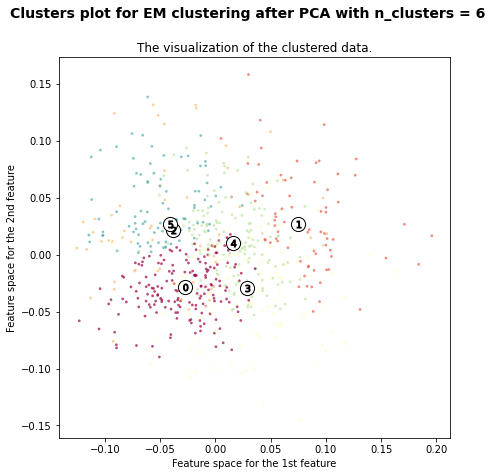

NMI score: 0.169999


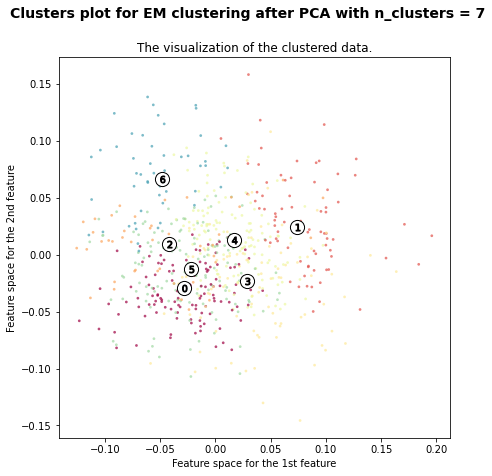

In [40]:
for n_clusters in range_n_clusters:
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_pca)
    cluster_labels = clusterer.predict(X_pca)
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    plt.scatter( X_pca.iloc[:, 1], X_pca.iloc[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_

    # Draw white circles at cluster centers
    plt.scatter(centers[:, 1], centers[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter( c[1], c[2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Clusters plot for EM clustering after PCA "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

## KMeans + ICA

NMI score: 0.081532
For n_clusters = 2 The average silhouette_score is : 0.35492239666821573


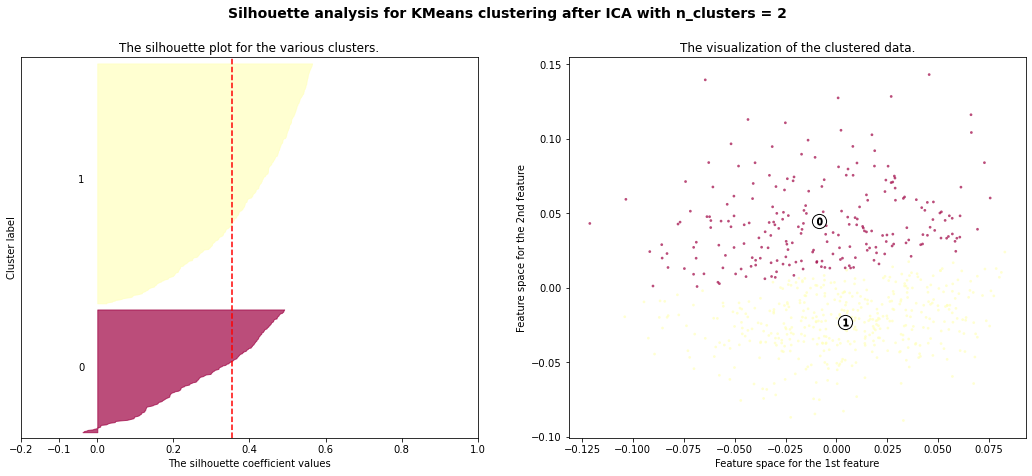

NMI score: 0.143548
For n_clusters = 3 The average silhouette_score is : 0.35929120681679994


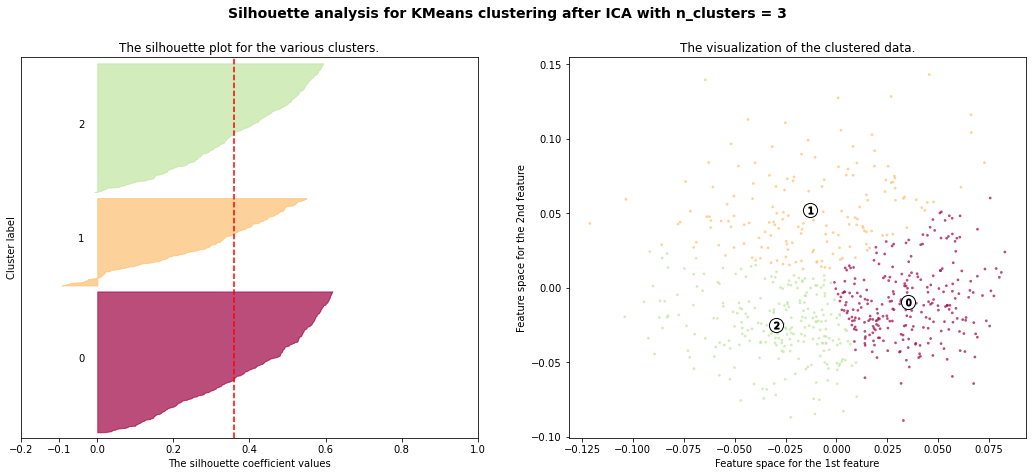

NMI score: 0.156543
For n_clusters = 4 The average silhouette_score is : 0.3553076039788076


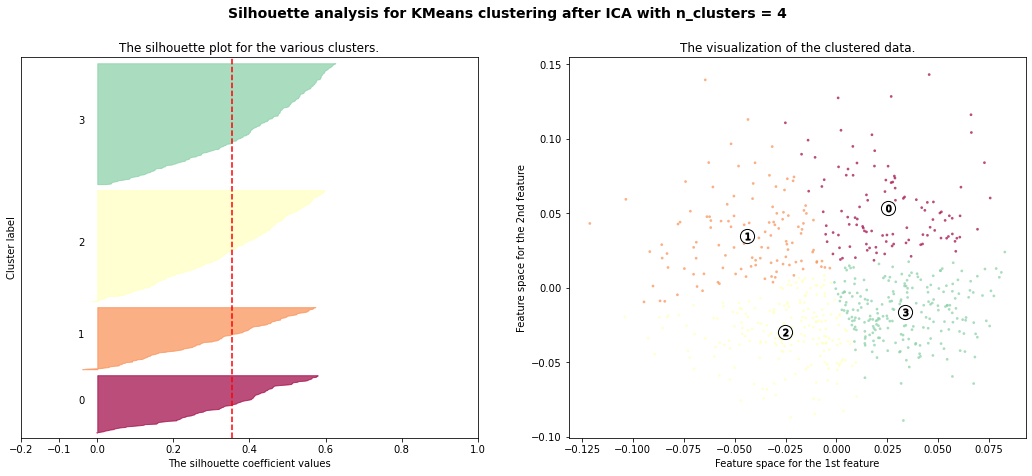

NMI score: 0.177811
For n_clusters = 5 The average silhouette_score is : 0.3389520069195708


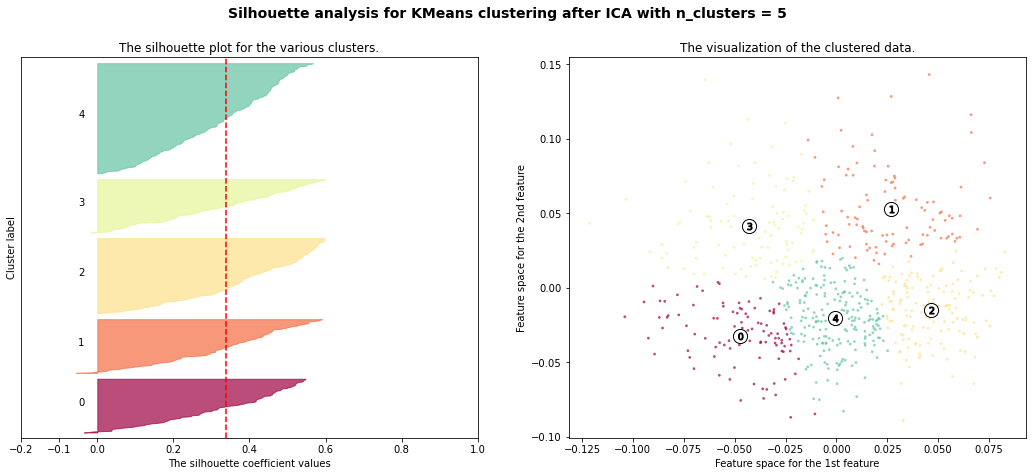

NMI score: 0.167970
For n_clusters = 6 The average silhouette_score is : 0.3488580506577998


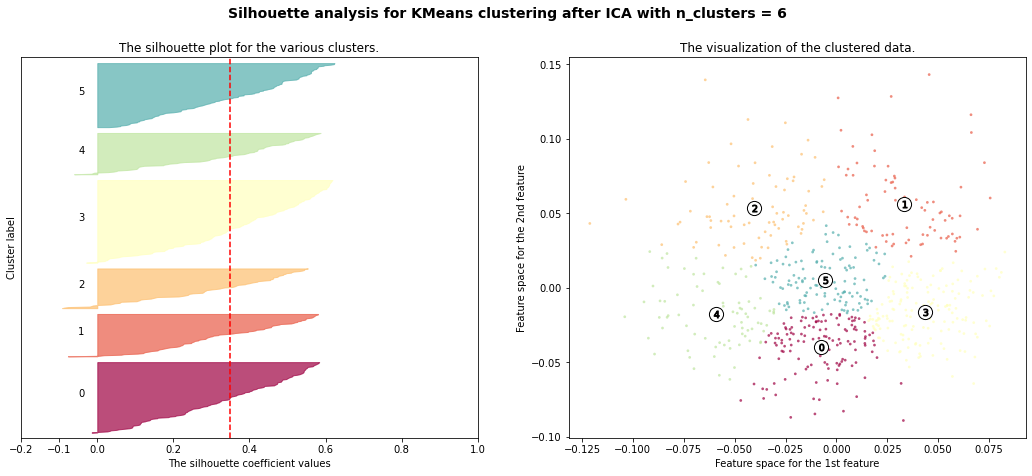

NMI score: 0.182287
For n_clusters = 7 The average silhouette_score is : 0.3425155476614691


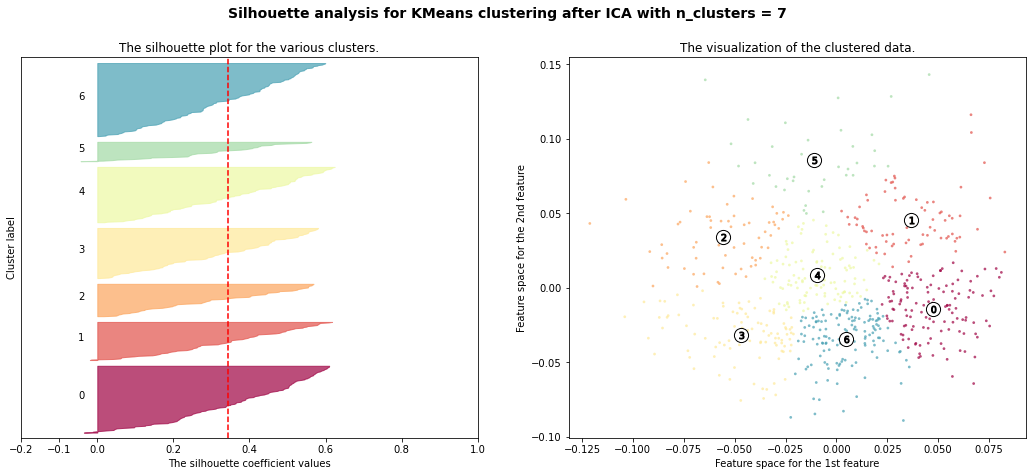

In [51]:
#K means clustering

range_n_clusters = [2,3,4,5,6,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_ica) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_ica)
    cluster_labels = clusterer.labels_
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_ica, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_ica, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter( X_ica.iloc[:, 0], X_ica.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter( c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering after ICA "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
#     ax2.axis([-5,5,-5,5])

    plt.show()

## GMM + ICA

NMI score: 0.078533


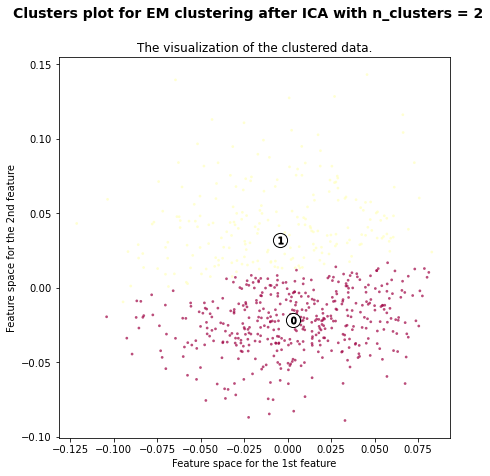

NMI score: 0.144929


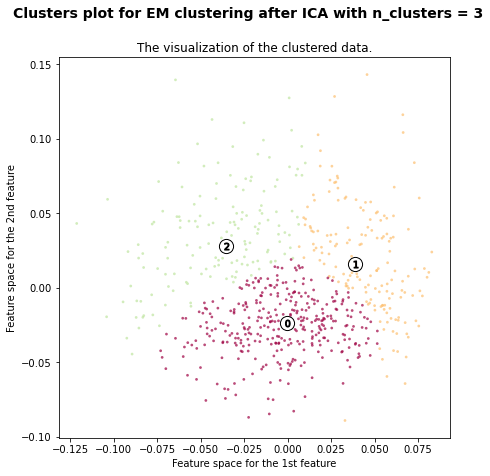

NMI score: 0.181343


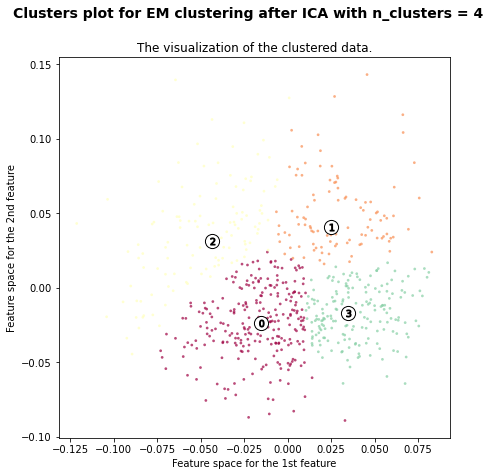

NMI score: 0.153480


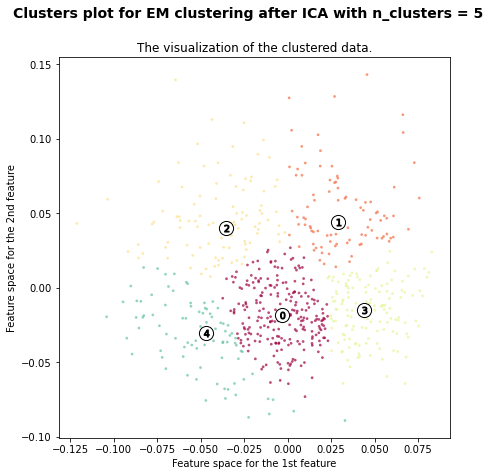

NMI score: 0.172469


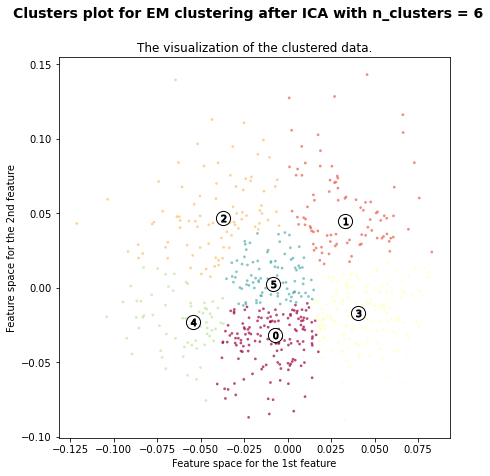

NMI score: 0.174655


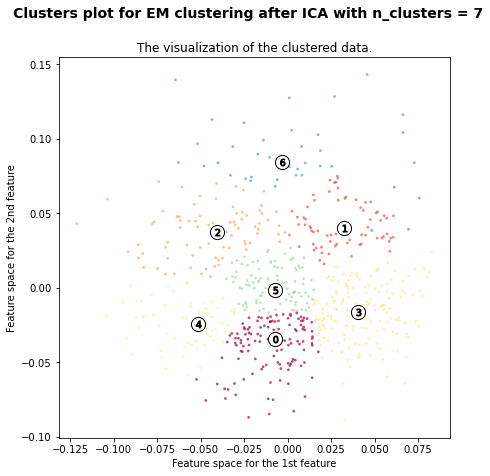

In [41]:
for n_clusters in range_n_clusters:
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_ica)
    cluster_labels = clusterer.predict(X_ica)
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    plt.scatter( X_ica.iloc[:, 0], X_ica.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_

    # Draw white circles at cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter( c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Clusters plot for EM clustering after ICA "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

## KMeans + RP

NMI score: 0.005488
For n_clusters = 2 The average silhouette_score is : 0.2043318435392022


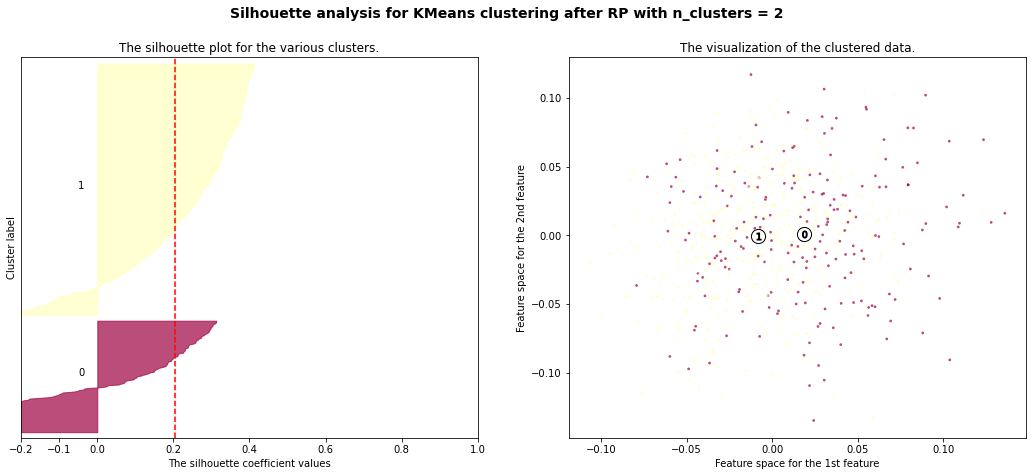

NMI score: 0.115774
For n_clusters = 3 The average silhouette_score is : 0.1274881450668329


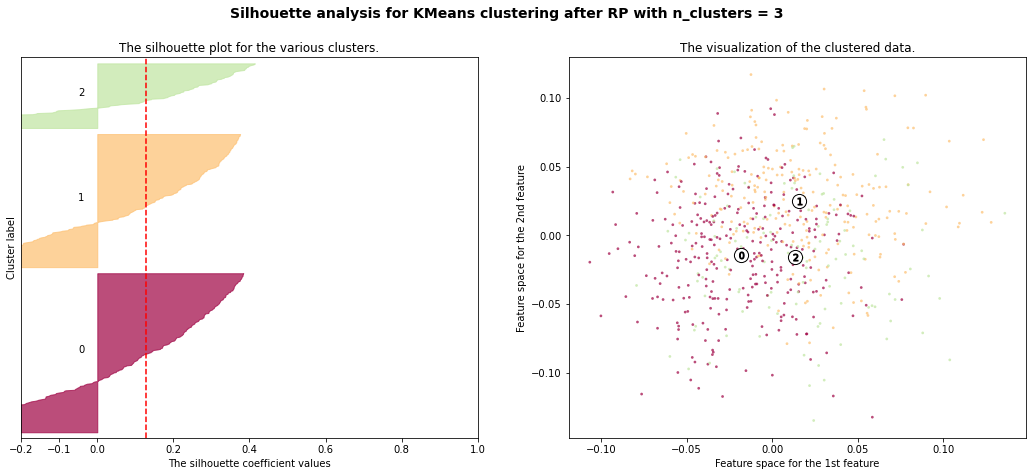

NMI score: 0.097001
For n_clusters = 4 The average silhouette_score is : 0.1284667630017118


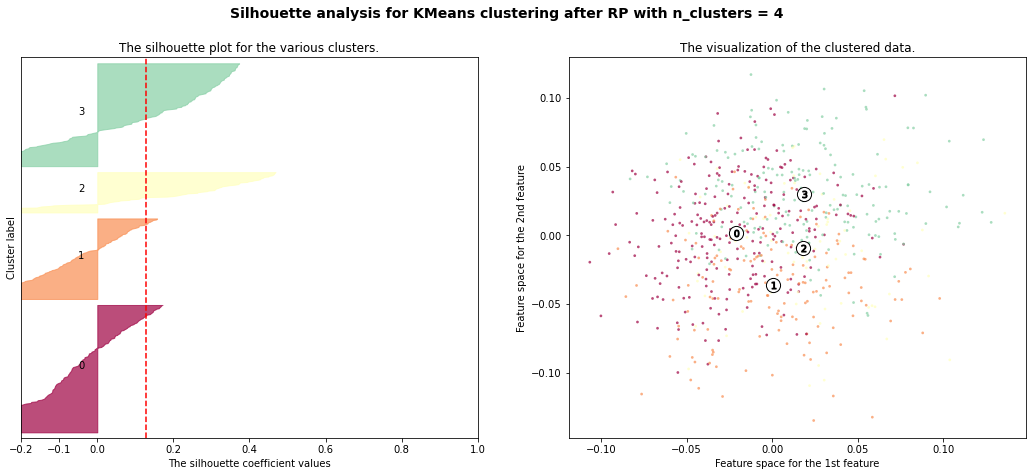

NMI score: 0.107582
For n_clusters = 5 The average silhouette_score is : 0.13156844240582863


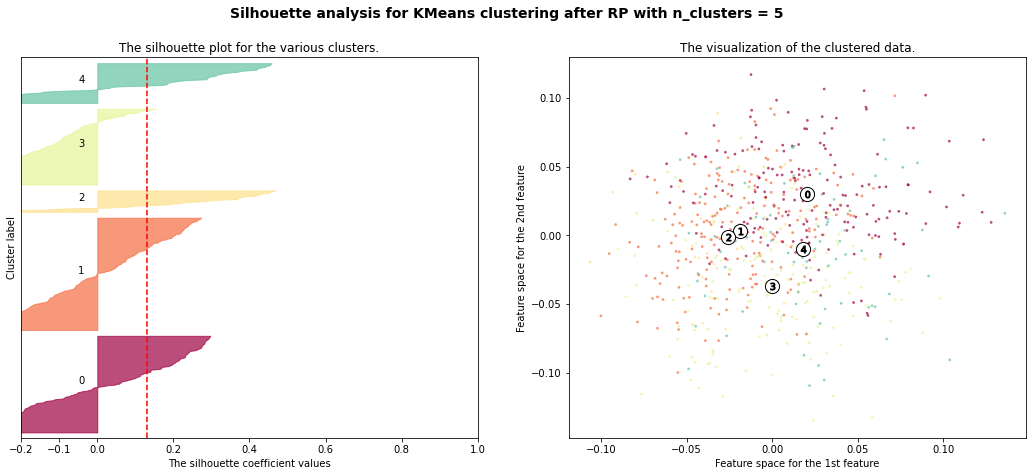

NMI score: 0.092030
For n_clusters = 6 The average silhouette_score is : 0.11564284123360485


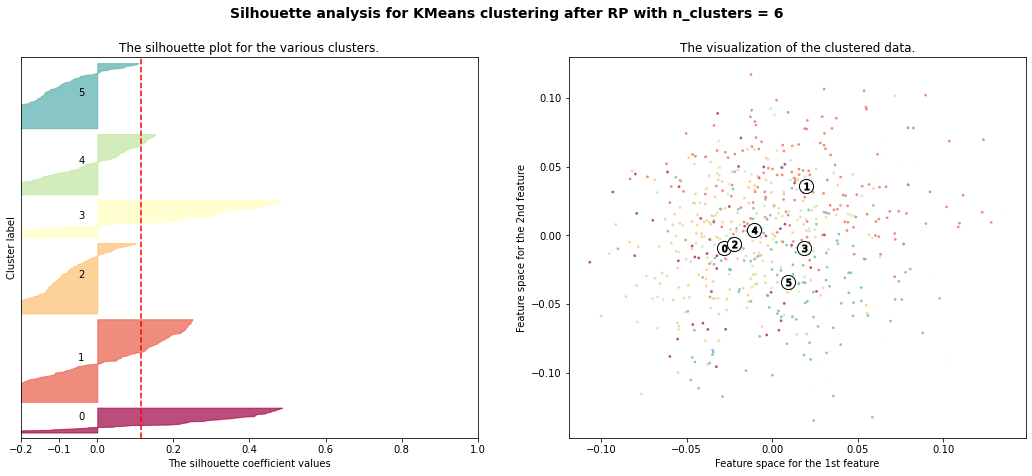

NMI score: 0.112032
For n_clusters = 7 The average silhouette_score is : 0.11496928157427574


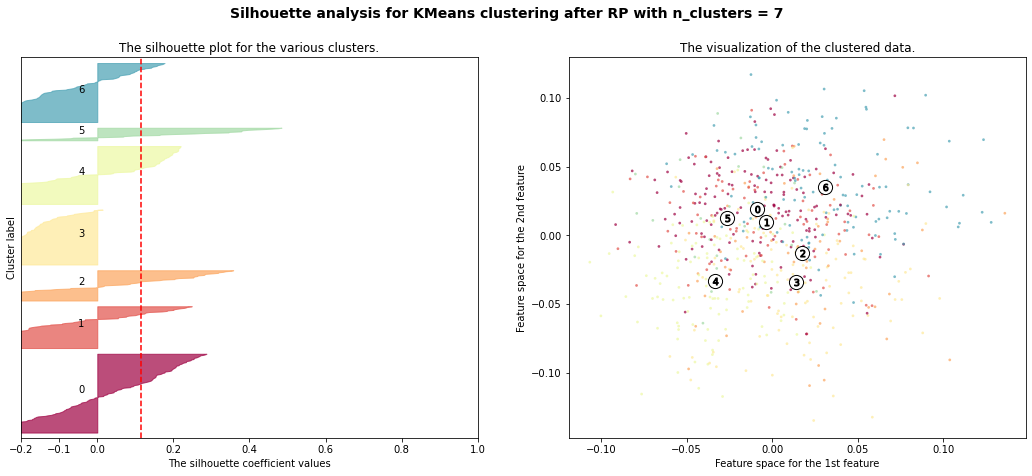

In [52]:
range_n_clusters = [2,3,4,5,6,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_rp) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_rp)
    cluster_labels = clusterer.labels_
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # X_rp
    silhouette_avg = silhouette_score(X_rp, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_ica, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter( X_rp.iloc[:, 0], X_rp.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter( c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering after RP "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
#     ax2.axis([-5,5,-5,5])

    plt.show()

## GMM + RP

NMI score: 0.104337


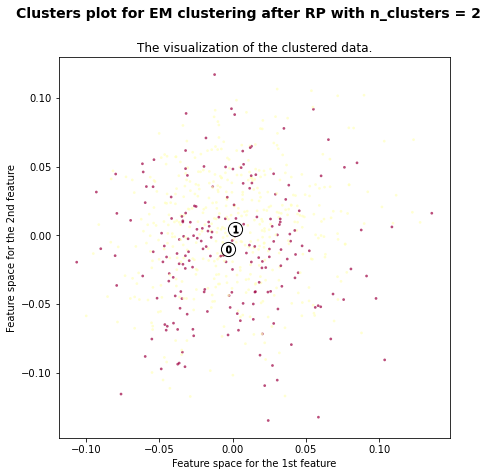

NMI score: 0.069905


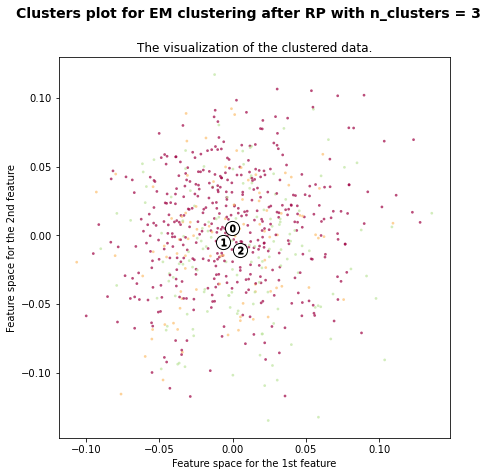

NMI score: 0.081524


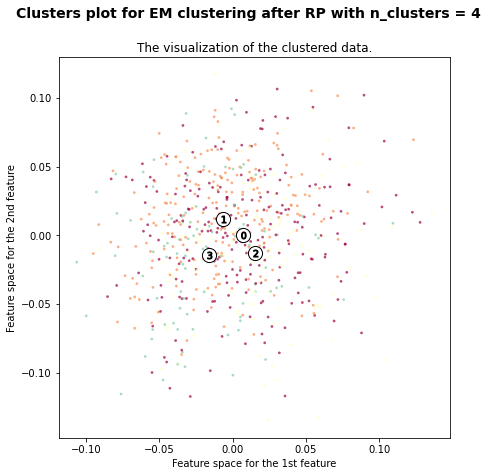

NMI score: 0.084054


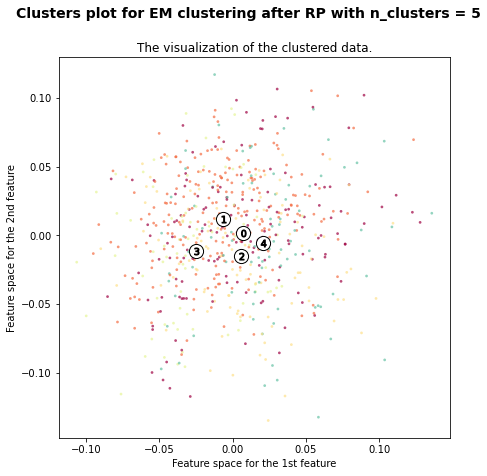

NMI score: 0.076857


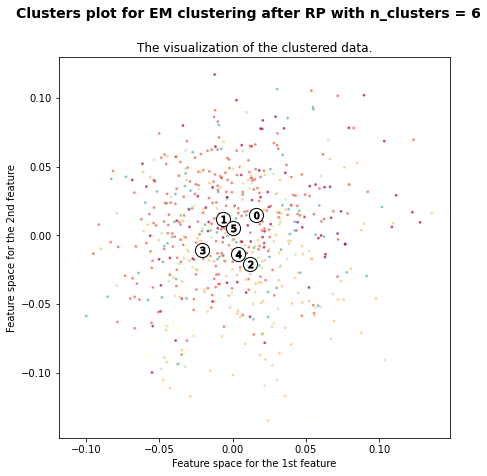

NMI score: 0.082434


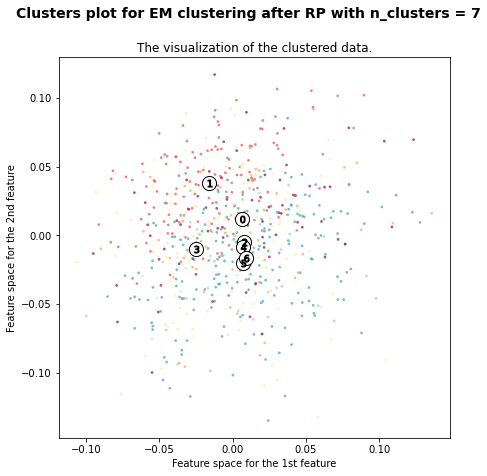

In [42]:
for n_clusters in range_n_clusters:
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_rp)
    cluster_labels = clusterer.predict(X_rp)
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    plt.scatter( X_rp.iloc[:, 0], X_rp.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_

    # Draw white circles at cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter( c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Clusters plot for EM clustering after RP "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

## KMeans + SVD

NMI score: 0.226852
For n_clusters = 2 The average silhouette_score is : 0.1443317832178029


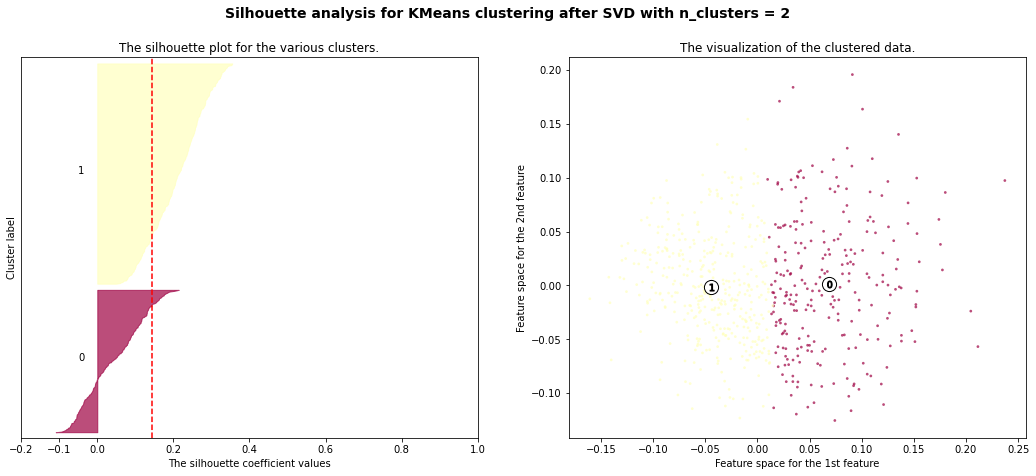

NMI score: 0.170241
For n_clusters = 3 The average silhouette_score is : 0.0969911039993937


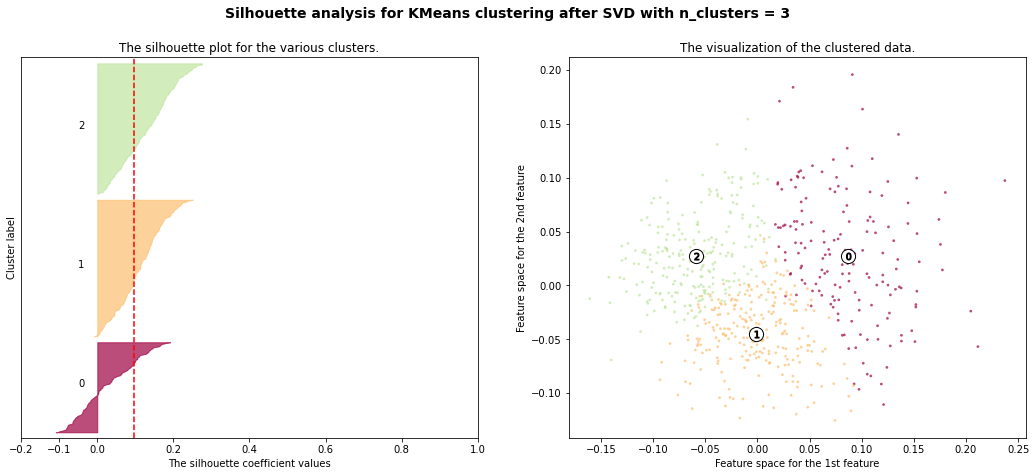

NMI score: 0.151156
For n_clusters = 4 The average silhouette_score is : 0.10172240568141311


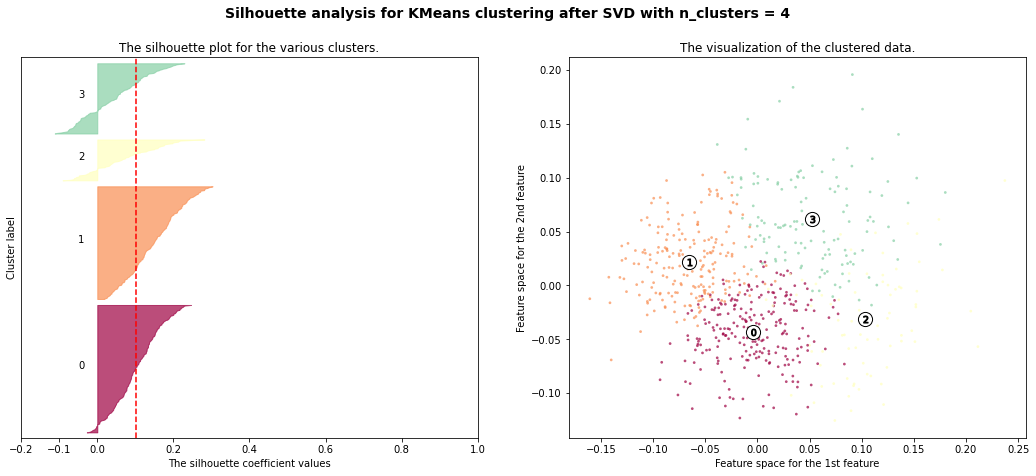

NMI score: 0.174281
For n_clusters = 5 The average silhouette_score is : 0.0864008835692731


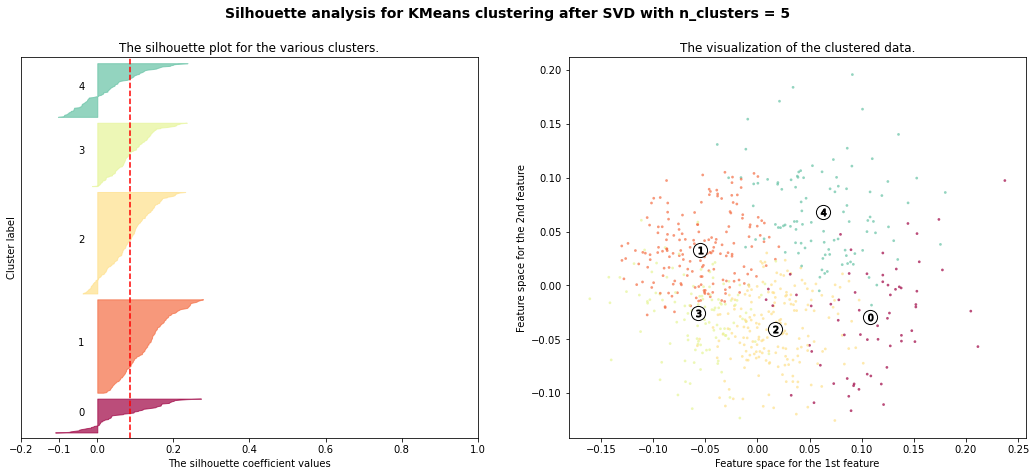

NMI score: 0.173378
For n_clusters = 6 The average silhouette_score is : 0.0822431052021558


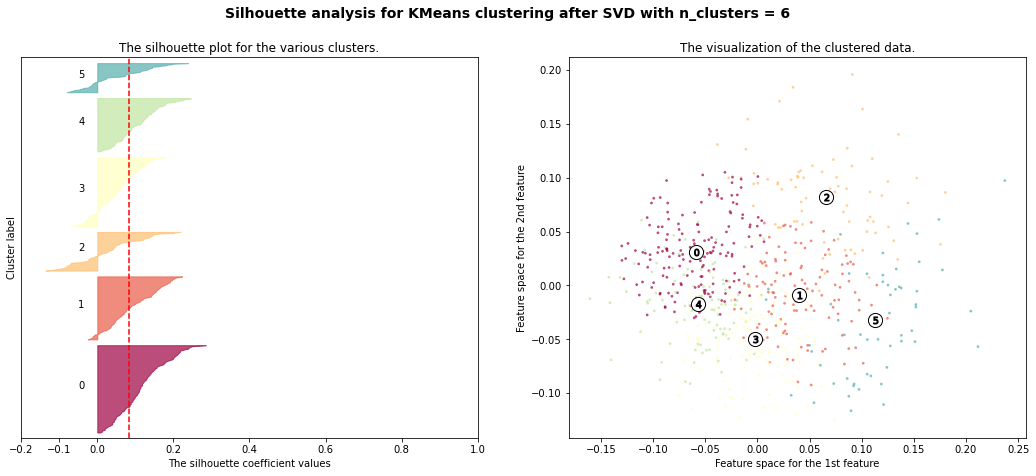

NMI score: 0.176079
For n_clusters = 7 The average silhouette_score is : 0.07938835497684098


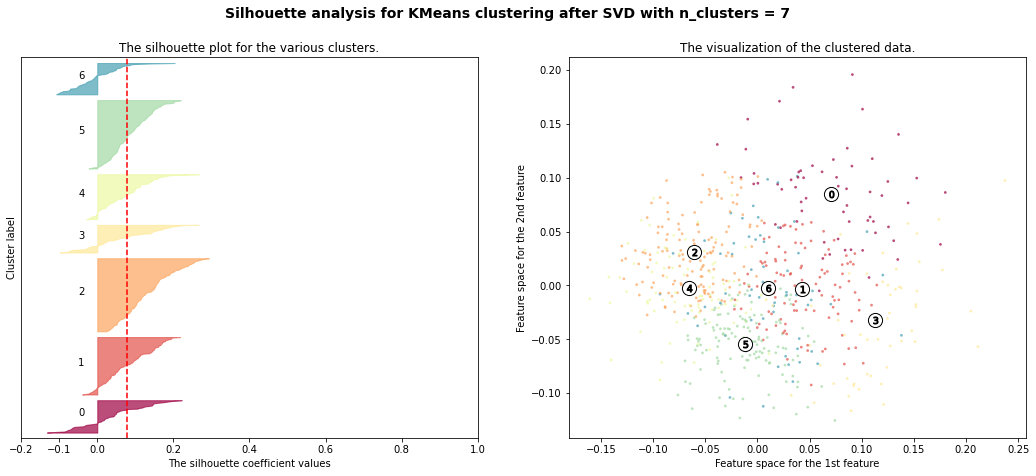

In [53]:
range_n_clusters = [2,3,4,5,6,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_svd) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_svd)
    cluster_labels = clusterer.labels_
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # X_rp
    silhouette_avg = silhouette_score(X_svd, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_svd, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter( X_svd.iloc[:, 0], X_svd.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter( c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering after SVD "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
#     ax2.axis([-5,5,-5,5])

    plt.show()

## GMM + SVD

NMI score: 0.118172


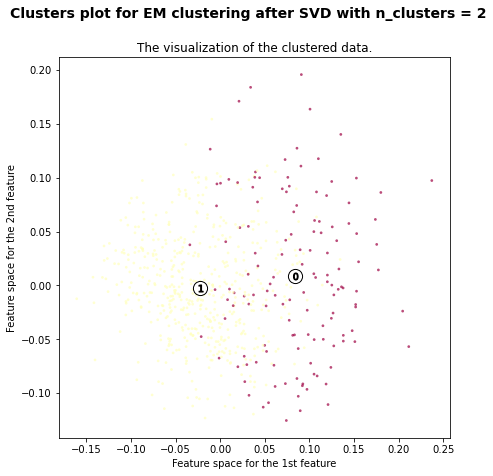

NMI score: 0.111660


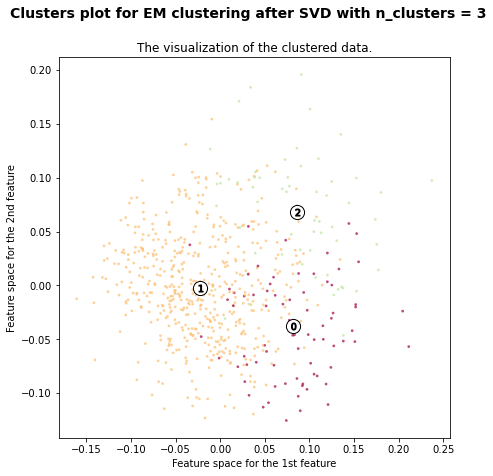

NMI score: 0.089278


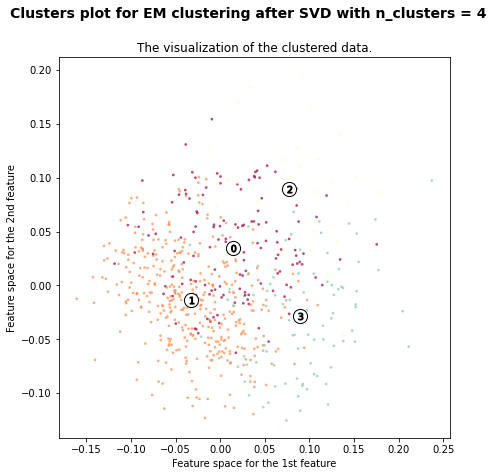

NMI score: 0.085711


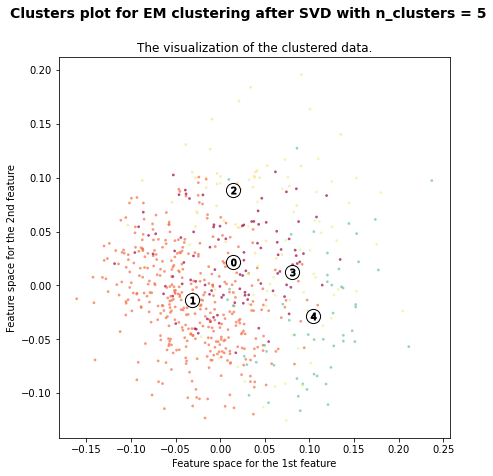

NMI score: 0.102308


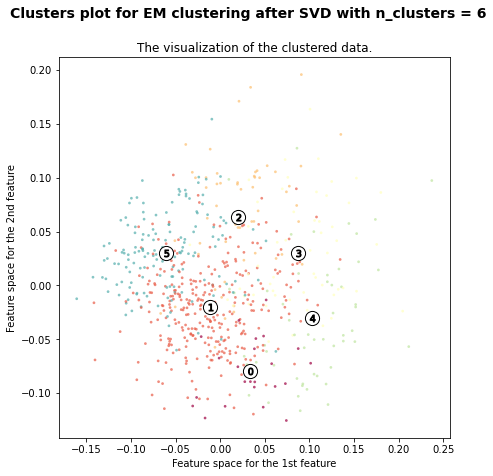

NMI score: 0.096652


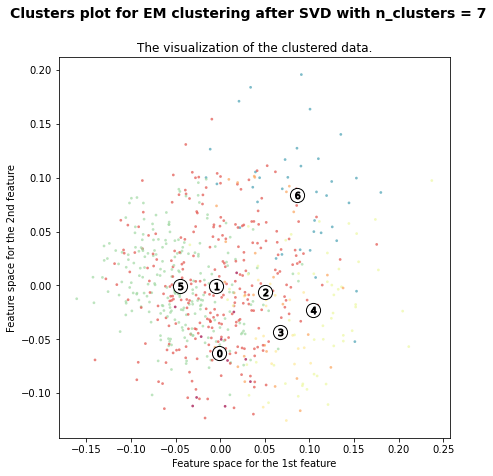

In [45]:
for n_clusters in range_n_clusters:
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_svd)
    cluster_labels = clusterer.predict(X_svd)
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    plt.scatter( X_svd.iloc[:, 0], X_svd.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_

    # Draw white circles at cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter( c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Clusters plot for EM clustering after SVD "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()